In [4]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.sparse import coo_matrix, csr_matrix

plt.style.use("ggplot")

#### Load data

In [5]:
ratings = pd.read_csv(os.path.join("..", "..", "data", "netflix", "ratings.csv"))

In [6]:
# nubmer of unique user Ids:
print("Number of unique users:", ratings.userId.nunique())

# nubmer of unique user Ids:
print("Number of unique movies:", ratings.movieId.nunique())

Number of unique users: 480189
Number of unique movies: 17770


In [7]:
ratings.head()

,userId,movieId,rating,timestamp
0,1488844,1,3.0,1125964800000000000
1,822109,1,5.0,1115942400000000000
2,885013,1,4.0,1129680000000000000
3,30878,1,4.0,1135555200000000000
4,823519,1,3.0,1083542400000000000


In [8]:
# Check and clean NaN values
print("Number of ratings Null values: ", max(ratings.isnull().sum()))

ratings.dropna(inplace=True)

Number of ratings Null values:  0


### Users data

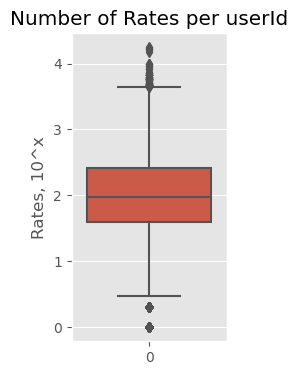

In [9]:
# Count the number of rows for each userId
# Plotting the boxplot
plt.figure(figsize=(2, 4))
sns.boxplot(data=np.log10(ratings.groupby("userId").size().values))
plt.ylabel("Rates, 10^x")
plt.title("Number of Rates per userId")
plt.show()

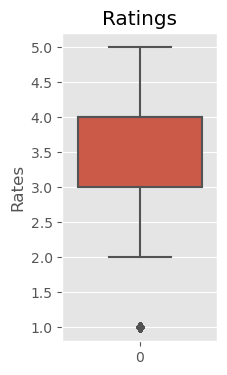

In [10]:
# Plotting the boxplot of rates distribution
plt.figure(figsize=(2, 4))
sns.boxplot(data=ratings.rating.values)
plt.ylabel("Rates")
plt.title("Ratings")
plt.show()

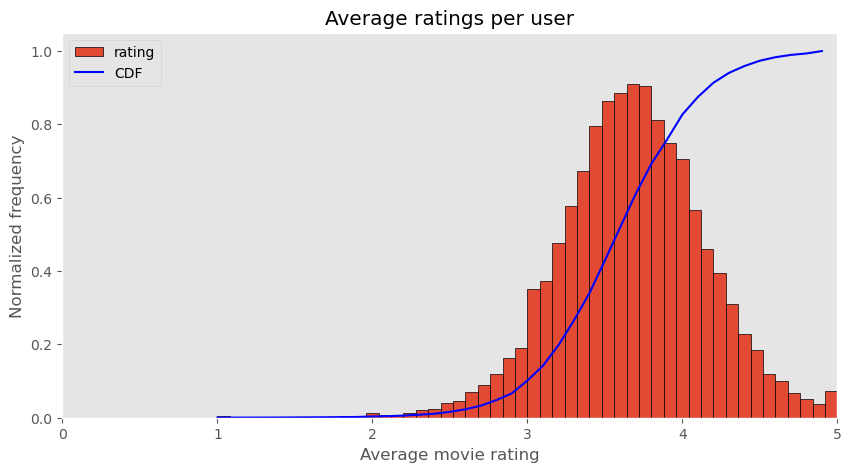

In [11]:
dftmp = ratings[["rating", "userId"]].groupby("userId").mean()
# Plot histogram
dftmp.plot(
    kind="hist", bins=50, grid=0, edgecolor="black", figsize=(10, 5), density=True
)
# Plot cumulative function on top (couldn't do any other way)
# evaluate the histogram
values, base = np.histogram(dftmp, bins=40, density=True)
# evaluate the cumulative (multiply by the average distance between points in the x-axis to get UNIT area)
cumulative = np.cumsum(values) * np.diff(base).mean()
# plot the cumulative function
plt.plot(base[:-1], cumulative, c="blue", label="CDF")
plt.xlim(0, 5)
plt.legend()
plt.xlabel("Average movie rating")
plt.ylabel("Normalized frequency")
plt.title("Average ratings per user")
plt.show()

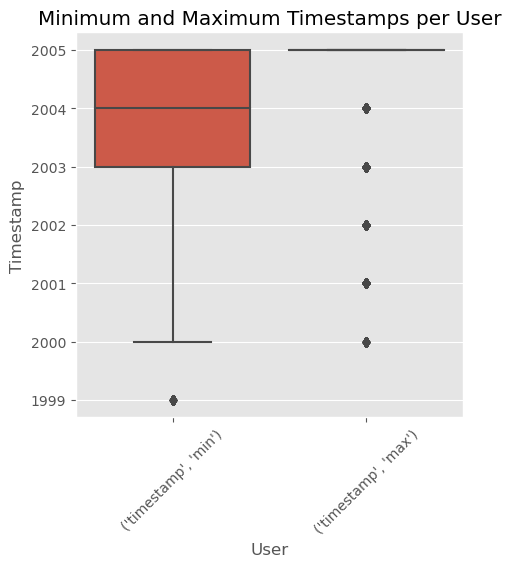

In [16]:
# Getting the minimum and maximum timestamps for each user
ratings['timestamp'] = pd.to_datetime(ratings["timestamp"])
user_timestamps = ratings.copy()
user_timestamps.timestamp = user_timestamps.timestamp.dt.year
user_timestamps = (
    user_timestamps[["timestamp", "userId"]].groupby("userId").agg(["min", "max"])
)

# Plotting the boxplots
plt.figure(figsize=(5, 5))
sns.boxplot(data=user_timestamps)
plt.xlabel("User")
plt.ylabel("Timestamp")
plt.title("Minimum and Maximum Timestamps per User")
plt.xticks(rotation=45)
plt.show()

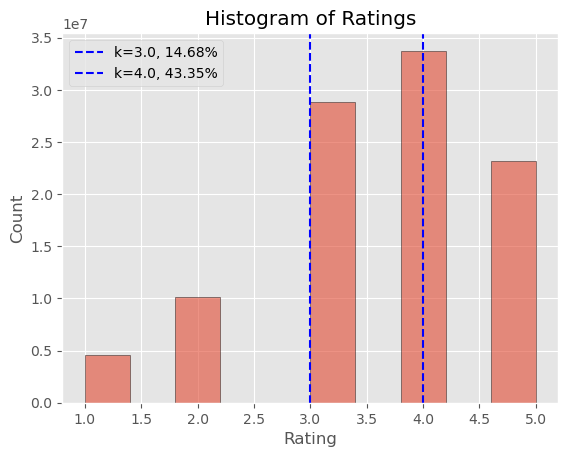

In [17]:
# Create a list of k values
k_values = [3.0, 4.0]

# Plot the histogram
plt.hist(ratings["rating"], bins=10, edgecolor="black", alpha=0.6)

for k in k_values:
    # Count the number of ratings less than k
    num_ratings_less_than_k = len(ratings[ratings["rating"] < k])

    # Calculate the total number of ratings
    total_ratings = len(ratings)

    # Calculate the percentage
    percentage_less_than_k = (num_ratings_less_than_k / total_ratings) * 100

    # Plot the vertical line for k
    plt.axvline(
        x=k, color="blue", linestyle="--", label=f"k={k}, {percentage_less_than_k:.2f}%"
    )

plt.xlabel("Rating")
plt.ylabel("Count")
plt.title("Histogram of Ratings")
plt.legend()
plt.show()

#### Lets make implicit dataset from explicit original one

In [18]:
# remove things < min_rating, and convert to implicit dataset
# by considering ratings as a binary preference only
min_rating = 4
ratings["rating"] = ratings["rating"].apply(lambda x: 0 if x < min_rating else 1)
ratings.reset_index(drop=True, inplace=True)

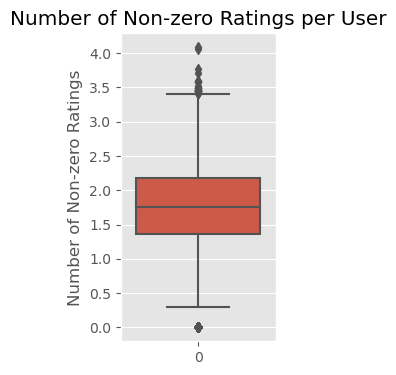

Median number of rates per movie: 57.00000000000001


In [19]:
# Filter the ratings DataFrame to include non-zero ratings
non_zero_ratings = ratings[ratings["rating"] != 0]

# Group by userId and calculate the count of non-zero ratings
user_rating_counts = non_zero_ratings.groupby("userId")["rating"].count()

# Create a boxplot
plt.figure(figsize=(2, 4))
sns.boxplot(data=np.log10(user_rating_counts).values)
plt.ylabel("Number of Non-zero Ratings")
plt.title("Number of Non-zero Ratings per User")
plt.show()

print("Median number of rates per movie:", 10 ** np.log10(user_rating_counts).median())

# Movies

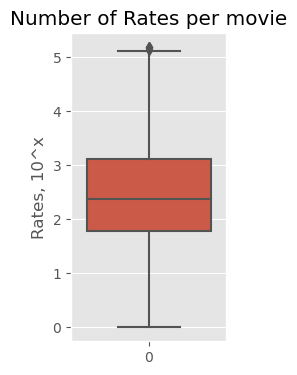

Median number of rates per movie: 237.00000000000006


In [21]:
# Count the number of rows for each movieId
user_row_counts = ratings[ratings.rating != 0].groupby("movieId").size()
# Plotting the boxplot
plt.figure(figsize=(2, 4))
sns.boxplot(data=np.log10(user_row_counts).values)
plt.ylabel("Rates, 10^x")
plt.title("Number of Rates per movie")
plt.show()

print("Median number of rates per movie:", 10 ** np.log10(user_row_counts).median())

### Filtering the initial dataset

Based on analysis, one may conclude that to make implicit dataset from explicit one we can use 4.0 threshold and filter 50% of rating.

To filter non-active users we can use median value of ratings = 57. \
To filter non-popular films we can use median value of ratings = 237.

In [22]:
# Create copy of intial dataset with filtered ratings >= 4.0
filtered_ratings = ratings[ratings.rating != 0].copy()

# Thresholds
movie_rating_threshold = 237
user_rating_threshold = 57

# Calculate the number of ratings for each movie and user
movie_ratings_counts = filtered_ratings["movieId"].value_counts()
user_ratings_counts = filtered_ratings["userId"].value_counts()

# Create boolean masks based on the rating thresholds
movie_threshold_mask = movie_ratings_counts >= movie_rating_threshold
user_threshold_mask = user_ratings_counts >= user_rating_threshold

# Apply the boolean masks to filter out the movies and users below the thresholds
filtered_ratings = filtered_ratings[
    filtered_ratings["movieId"].map(movie_threshold_mask)
]
filtered_ratings = filtered_ratings[filtered_ratings["userId"].map(user_threshold_mask)]

#### Since there are some omissions lets create new IDs for users and movies

In [23]:
# Create userId_new column with unique numerical values
filtered_ratings["userId_new"] = pd.factorize(filtered_ratings["userId"])[0]

# Create movieId_new column with unique numerical values
filtered_ratings["movieId_new"] = pd.factorize(filtered_ratings["movieId"])[0]

In [25]:
filtered_ratings = filtered_ratings.reset_index(drop=True)
filtered_ratings = filtered_ratings[
    ["userId", "userId_new", "movieId", "movieId_new", "rating", "timestamp"]
]
filtered_ratings

,userId,userId_new,movieId,movieId_new,rating,timestamp
0,822109,0,1,0,1,2005-05-13
1,885013,1,1,0,1,2005-10-19
2,30878,2,1,0,1,2005-12-26
3,1842128,3,1,0,1,2004-05-09
4,2207774,4,1,0,1,2005-06-06
...,...,...,...,...,...,...
50450687,564449,137749,17769,8885,1,2005-07-11
50450688,2361882,90460,17769,8885,1,2004-07-13
50450689,391432,90412,17769,8885,1,2004-12-31
50450690,1428223,102368,17769,8885,1,2005-02-01
